In [121]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

In [303]:
CITY = 'Memphis'

In [306]:
od_data = pd.read_csv(f'./outputs/{CITY}_transit_drive_walk.csv', index_col=0)
od_data['h_geocode'] = od_data['h_geocode'].astype(str)

cbg = gpd.read_file('../data/tl_2022_47_bg.zip')[['GEOID', 'geometry']]
cbg['GEOID'] = cbg['GEOID'].astype(str)

tn_city_boundaries = gpd.read_file("zip:///home/rishav/Programs/move_od/data/TN_City_Boundaries.zip")
city_limits = tn_city_boundaries[tn_city_boundaries['NAME'] == CITY]
city_limits = city_limits.to_crs('EPSG:4326')

/tmp/ipykernel_89461/2838501732.py:1: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  od_data = pd.read_csv(f'./outputs/{CITY}_transit_drive_walk.csv', index_col=0)


<AxesSubplot:>

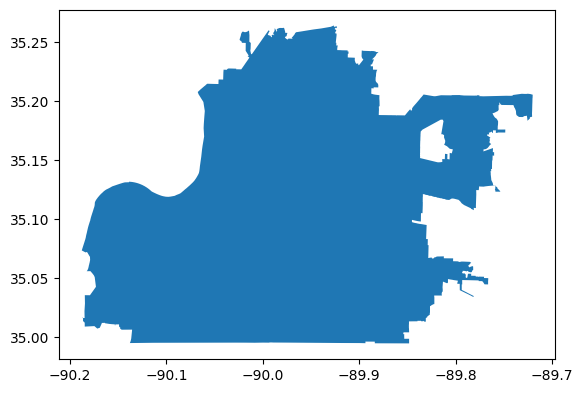

In [307]:
city_limits.plot()

In [159]:
cbg2 = cbg.to_crs(city_limits.crs)
temp = cbg2.sjoin(city_limits)
temp['transit_score'] = 0
temp = temp[['GEOID', 'geometry', 'transit_score']]
temp = temp.to_crs(epsg=4326)
temp.to_csv(f'./outputs/{CITY}_ts_0.csv')

In [143]:
od_data['transit_score'] = od_data['drive_time']/od_data['transit_time']

In [144]:
# od_data = od_data.dropna(subset=['transit_score'])
mean_transit_scores = od_data.groupby(['h_geocode']).agg({'transit_score': 'mean', 'total_jobs': 'first'}).reset_index()
mean_transit_scores = mean_transit_scores.merge(cbg, left_on='h_geocode', right_on='GEOID', how='left')
mean_transit_scores['transit_score'] = mean_transit_scores['transit_score'].fillna(0)

In [141]:
# mean_transit_scores['geometry'] = mean_transit_scores['geometry'].apply(wkt.loads)
mean_transit_scores = gpd.GeoDataFrame(mean_transit_scores, geometry='geometry', crs='EPSG:4326')
mean_transit_scores = mean_transit_scores.to_crs(city_limits.crs)

mean_transit_scores = mean_transit_scores[mean_transit_scores.geometry.within(city_limits.unary_union)]

In [145]:
mean_transit_scores

,h_geocode,transit_score,total_jobs,GEOID,geometry
0,470650004001,0.370653,31.0,470650004001,"POLYGON ((-85.27190 35.04104, -85.27182 35.041..."
1,470650004003,0.371022,41.0,470650004003,"POLYGON ((-85.29729 35.05109, -85.29727 35.051..."
2,470650006001,0.335802,8.0,470650006001,"POLYGON ((-85.30907 35.06679, -85.30905 35.067..."
3,470650006002,0.330890,39.0,470650006002,"POLYGON ((-85.30483 35.06175, -85.30473 35.061..."
4,470650006003,0.364201,1.0,470650006003,"POLYGON ((-85.30922 35.05882, -85.30905 35.059..."
...,...,...,...,...,...
164,470650123003,0.342230,12.0,470650123003,"POLYGON ((-85.28879 35.05388, -85.28877 35.054..."
165,470650124001,0.443321,11.0,470650124001,"POLYGON ((-85.30551 35.04754, -85.30546 35.047..."
166,470650124002,0.423362,13.0,470650124002,"POLYGON ((-85.30150 35.04613, -85.30120 35.046..."
167,470650124003,0.403172,1.0,470650124003,"POLYGON ((-85.30756 35.03952, -85.30741 35.039..."


In [146]:
mean_transit_scores.dropna(subset='transit_score').to_csv(f'./outputs/{CITY}_ts.csv')

## Combine scores

In [318]:
import glob
import os

folder_path = './outputs/'
pattern = os.path.join(folder_path, '*_transit_drive_walk.csv')

file_list = glob.glob(pattern)
df_list = [pd.read_csv(file, index_col=0, low_memory=False) for file in file_list]
combined_df = pd.concat(df_list, ignore_index=True)

In [432]:
CITIES = ['Nashville', 'Chattanooga', 'Memphis', 'Knoxville']

cbg = gpd.read_file('../data/tl_2022_47_bg.zip')[['GEOID', 'geometry']]
cbg['GEOID'] = cbg['GEOID'].astype(str)

tn_city_boundaries = gpd.read_file("/home/rishav/Programs/move_od/data/TN_City_Boundaries.geojson")
city_limits = pd.DataFrame()
for city in CITIES:
    city_limits = pd.concat([city_limits, tn_city_boundaries[tn_city_boundaries['NAME'] == city]])

city_limits = city_limits.to_crs('EPSG:4326')
cbg = cbg.to_crs('EPSG:4326')

In [364]:
city_limits.to_csv('./outputs/city_limits.csv')

In [433]:
combined_df['transit_score'] = combined_df['drive_time']/combined_df['transit_time']
combined_df['h_geocode'] = combined_df['h_geocode'].astype(str)
mean_transit_scores = combined_df.groupby(['h_geocode']).agg({'transit_score': 'mean', 'total_jobs': 'first'}).reset_index()

cbg_cities = cbg.sjoin(city_limits, predicate='intersects', how='inner')[['GEOID', 'geometry']]
mean_transit_scores = mean_transit_scores.merge(cbg_cities, left_on='h_geocode', right_on='GEOID')
# mean_transit_scores = mean_transit_scores.merge(cbg, left_on='h_geocode', right_on='GEOID', how='left')
mean_transit_scores['transit_score'] = mean_transit_scores['transit_score'].fillna(0)

In [434]:
mean_transit_scores.to_csv('./outputs/combined_ts.csv')

In [435]:
income = gpd.read_file('./outputs/income_tn.geojson')

In [436]:
gpd.GeoDataFrame(mean_transit_scores[['GEOID', 'geometry']].merge(income[['estimate', 'margin_of_error', 'GEOID']], on='GEOID', how='inner')).to_csv('./outputs/income_truncated.csv')

: 